### Task #1 - Engineering
Given a set of documents: create a solution that allows the end user to understand
the documents in a two dimensional space and to identify outliers.

Dataset
* Year: 2020
* Filing type: 10K
* Sections: All
* Companies: Limit to 10.
  
Steps
* Convert the documents to chunks,
* Convert the chunks into embeddings,
* Standard scale the embeddings,
* Perform principal components analysis,
* Apply dimensionality reduction,
* Perform Kmeans clustering and assign chunks an cluster number.
* Create an outlier flag.
  
Plot(s)
* Embeddings in 2 dimensions
* Colored by assigned clusters.
* Colored by outlier flag
* Colored by section number.

In [ ]:
# Set up Environment 
# pyspark       - large-scale data manipulation with pyspark
# transformers  - NLP processing
# torch         - used for deep learning
# datasets      - access and manage datasets
# matplotlib    - data visualization
# scikit-learn  - ML library

!pip install pyspark transformers torch datasets matplotlib scikit-learn

In [2]:
# Error debugging
# !python3 -m pip install --upgrade pip

ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [23]:
#import Libraries
import pandas as pd
from datasets import load_dataset
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Download the required NLTK tokenizers
nltk.download('punkt')
nltk.download('punkt_tab')  # Additional resource for sentence tokenization

[nltk_data] Downloading package punkt to /Users/dprempeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dprempeh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [1]:
# Set working Directory
import os
# current_path = os.getcwd()
# current_path

In [13]:
# Set RooT Dir
ROOT_DIR ="/Users/Vader/Documents/Notebook_GenAI_Projects/AIG_Assessment"

Datafile : https://huggingface.co/datasets/eloukas/edgar-corpus

sample online:
Data Splits

* Config	Training	Validation	Test
* full	176,289	22,050	22,036
* year_1993	1,060	133	133
* year_1994	2,083	261	260
* year_1995	4,110	514	514
* year_1996	7,589	949	949
* year_1997	8,084	1,011

In [16]:
# Due to large file size and system constraints, file woudl be loaded in streaming mode
# Load the dataset in streaming mode
# Company identifiers are stored in the cik field (Central Index Key)

from datasets import load_dataset
import pandas as pd

# Load dataset for 2020 (year-specific config)
dataset = load_dataset("eloukas/edgar-corpus", "year_2020", streaming=True, split="train")

# Collect 10 unique CIKs (companies)
selected_ciks = set()
for sample in dataset:
    if len(selected_ciks) < 10:
        selected_ciks.add(sample['cik'])
    else:
        break

# Reload and filter the dataset for selected CIKs
filtered_dataset = dataset.filter(lambda x: x['cik'] in selected_ciks)

# Convert to pandas DataFrame (limit to 100 samples)
samples = []
for i, sample in enumerate(filtered_dataset):
    if i >= 100:
        break
    samples.append(sample)

df = pd.DataFrame(samples)

In [17]:
df.head(5)

,filename,cik,year,section_1,section_1A,section_1B,section_2,section_3,section_4,section_5,...,section_8,section_9,section_9A,section_9B,section_10,section_11,section_12,section_13,section_14,section_15
0,718413_2020.htm,718413,2020,Item 1. The Business\nOrganization and Operati...,Item 1A. Risk Factors\nBefore deciding to inve...,Item 1B. Unresolved Staff Comments\nNot Applic...,Item 2. Properties\nAlthough the Company does ...,Item 3. Legal Proceedings\nThere are no pendin...,Item 4. Mine Safety Disclosures\nNot Applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nDisclosure C...,Item 9B. Other Information\nNone\nPART III.\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe following...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
1,931059_2020.htm,931059,2020,"Item 1. Business\nRennova Health, Inc. (“Renno...",Item 1A. Risk Factors\nAn investment in our se...,Item 1B. Unresolved Staff Comments\nNot applic...,Item 2. Properties\nThe table below summarizes...,"Item 3. Legal Proceedings\nFrom time to time, ...",Item 4. Mine Safety Disclosures\nNot applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements With Acco...,Item 9A. Controls and Procedures.\nEvaluation ...,Item 9B. Other Information.\nNone\nPART III\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation.\nThe followin...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,"Item 15. Exhibits, Financial Statement Schedul..."
2,1282224_2020.htm,1282224,2020,ITEM 1. BUSINESS\nOverview\nWe are a leading i...,ITEM 1A. RISK FACTORS\nRisks Related to our Bu...,ITEM 1B. UNRESOLVED STAFF COMMENTS\nNone.\nITE...,ITEM 2. PROPERTIES\nAs of the date of this rep...,ITEM 3. LEGAL PROCEEDINGS\nWe currently do not...,ITEM 4. MINE SAFETY DISCLOSURES\nNot applicabl...,"ITEM 5. MARKET FOR REGISTRANT’S COMMON EQUITY,...",...,ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY...,ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCO...,ITEM 9A. CONTROLS AND PROCEDURES\nManagement’s...,ITEM 9B. OTHER INFORMATION\nItem 3.02 Unregist...,"ITEM 10. DIRECTORS, EXECUTIVE OFFICERS, AND CO...",ITEM 11. EXECUTIVE COMPENSATION\nThe informati...,ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFIC...,ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRA...,ITEM 14. PRINCIPAL ACCOUNTING FEES AND SERVICE...,"ITEM 15. EXHIBITS, FINANCIAL STATEMENT SCHEDUL..."
3,723531_2020.htm,723531,2020,Item 1. Business\nUnless we state otherwise or...,Item 1A. Risk Factors\nOur future results of o...,Item 1B. Unresolved Staff Comments\nNone.\nIte...,Item 2. Properties\nWe owned and leased the fo...,Item 3. Legal Proceedings\nWe are subject to v...,Item 4. Mine Safety Disclosures\nNot applicabl...,"Item 5. Market for Registrant’s Common Equity,...",...,Item 8. Financial Statements and Supplementary...,Item 9. Changes in and Disagreements with Acco...,Item 9A. Controls and Procedures\nDisclosure C...,Item 9B. Other Information\nNone.\nPART III\nI...,"Item 10. Directors, Executive Officers and Cor...",Item 11. Executive Compensation\nThe informati...,Item 12. Security Ownership of Certain Benefic...,Item 13. Certain Relationships and Related Tra...,Item 14. Principal Accounting Fees and Service...,Item 15. Exhibits and Financial Statement Sche...
4,1490873_2020.htm,1490873,2020,ITEM 1.\nBUSINESS\nCorporate Overview\nThe Com...,ITEM 1A.\nRISK FACTORS\nThe Company is a small...,ITEM 1B.\nUNRESOLVED STAFF COMMENTS\nNone.\nIT...,ITEM 2.\nPROPERTIES\nThe Company's corporate h...,"IT

In [18]:
df.shape

(10, 23)

In [19]:
df.columns

Index(['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B',
       'section_2', 'section_3', 'section_4', 'section_5', 'section_6',
       'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A',
       'section_9B', 'section_10', 'section_11', 'section_12', 'section_13',
       'section_14', 'section_15'],
      dtype='object')

In [24]:
# Chunk Documents into Sentences

def chunk_document(text):
    """Split text into sentences using NLTK."""
    return nltk.sent_tokenize(text)

# Combine all sections into a single text column
section_columns = [col for col in df.columns if col.startswith('section_')]
df['text'] = df[section_columns].apply(
    lambda row: ' '.join(str(val) for val in row if pd.notnull(val)), 
    axis=1
)

# Split into sentences and explode
df['chunks'] = df['text'].apply(chunk_document)
chunk_df = df.explode('chunks').reset_index(drop=True)

# Remove empty chunks
chunk_df = chunk_df[chunk_df['chunks'].str.strip().astype(bool)]


In [36]:
# Chunk Documents into Sentences

# Explode sections into separate rows (each row is one section)
section_columns = [col for col in df.columns if col.startswith('section_')]

# Drop the temporary "text" column if it exists
if 'text' in df.columns:
    df = df.drop(columns=['text'])

# Melt sections into rows
df_sections = df.melt(
    id_vars=['cik', 'year'], 
    value_vars=section_columns, 
    var_name='section', 
    value_name='text'  # Now safe to use "text" as the melted value name
).dropna()

# Split into chunks
df_sections['chunks'] = df_sections['text'].apply(chunk_document)
chunk_df = df_sections.explode('chunks').reset_index(drop=True)
chunk_df = chunk_df[chunk_df['chunks'].str.strip().astype(bool)]
chunk_df['section'] = chunk_df['section'].str.replace('section_', '')

In [37]:
# Generate Embeddings

# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for all chunks
embeddings = model.encode(chunk_df['chunks'].tolist(), show_progress_bar=True)

# Add embeddings to DataFrame
chunk_df['embedding'] = list(embeddings)


Batches: 100%|████████████████████████████████| 476/476 [00:10<00:00, 43.44it/s]


In [38]:
# Standard Scaling

# Convert embeddings to a numpy array
X = np.array(chunk_df['embedding'].tolist())

# Standardize the embeddings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Dimensionality Reduction with PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to DataFrame
chunk_df['pca1'] = X_pca[:, 0]
chunk_df['pca2'] = X_pca[:, 1]

In [40]:
#  KMeans Clustering

# Cluster data into 5 groups
kmeans = KMeans(n_clusters=5, random_state=42)
chunk_df['cluster'] = kmeans.fit_predict(X_pca)

In [41]:
# Outlier Detection

# Calculate distance from each point to its cluster center
distances = kmeans.transform(X_pca)
chunk_df['distance'] = distances[np.arange(len(distances)), chunk_df['cluster']]

# Flag points in the top 5% distances as outliers
threshold = np.percentile(chunk_df['distance'], 95)
chunk_df['outlier'] = (chunk_df['distance'] > threshold).astype(int)

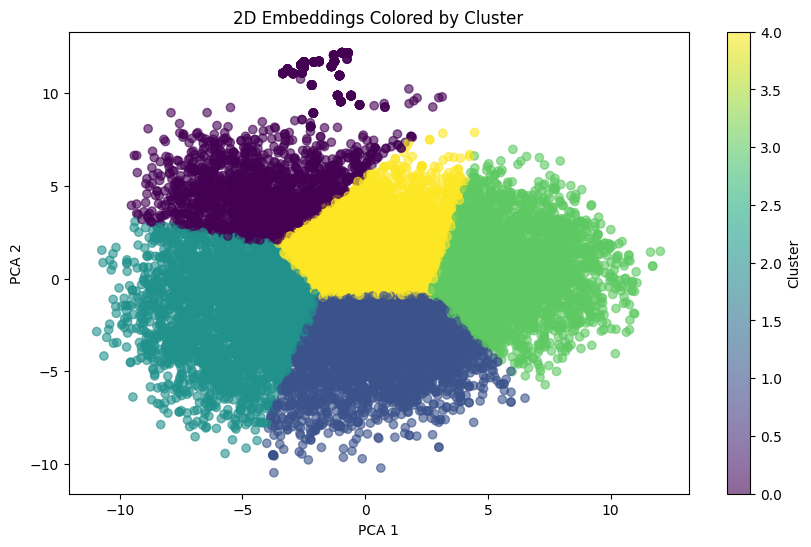

In [42]:
# Generate Plots

# Plot colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(chunk_df['pca1'], chunk_df['pca2'], c=chunk_df['cluster'], cmap='viridis', alpha=0.6)
plt.title('2D Embeddings Colored by Cluster')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.savefig('cluster_plot.jpg')
plt.show()




In [45]:
# Cluster representation

for cluster_id in chunk_df['cluster'].unique():
    print(f"\nCluster {cluster_id} Examples:")
    samples = chunk_df[chunk_df['cluster'] == cluster_id]['chunks'].sample(3).tolist()
    for sample in samples:
        print(f"- {sample}")


Cluster 0 Examples:
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
- Within Paychex’s HCM solutions, Paychex offers a comprehensive portfolio of services and products that allow its clients to meet their diverse HR and payroll needs.
- We compete on the basis of a number of factors, including equipment availability, quality, price, service, reliability, appearance, functionality and delivery terms.
- Item 12.

Cluster 4 Examples:
- Medicare generally pays for inpatient and outpatient services at prospectively determined rates based on clinical, diagnostic and other factors.
- Note 5 - Property and Equipment
Property and equipment at December 31, 2020 and 2019 consisted of the following:
On March 5, 2019, the Company acquired certain assets and liabilities related to Jellico Community Hospital and CarePlus Center.
- In 2006 to 2010 he was chief executive officer of Shell Business 

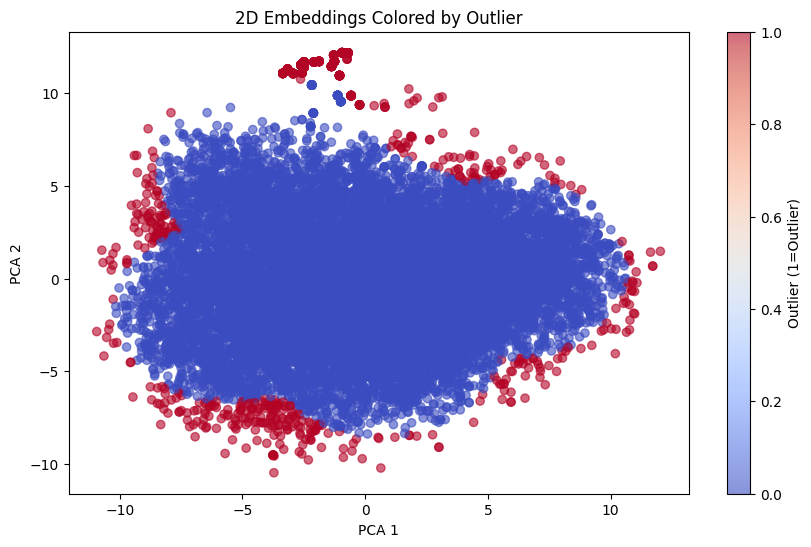

In [43]:
# Plot colored by outlier
plt.figure(figsize=(10, 6))
plt.scatter(chunk_df['pca1'], chunk_df['pca2'], c=chunk_df['outlier'], cmap='coolwarm', alpha=0.6)
plt.title('2D Embeddings Colored by Outlier')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Outlier (1=Outlier)')
plt.savefig('outlier_plot.jpg')
plt.show()


In [47]:
outlier_sentences = chunk_df[chunk_df['outlier'] == 1]['chunks'].tolist()
print("Top Outliers:")
for sentence in outlier_sentences[:5]:
    print(f"- {sentence}")

Top Outliers:
- Item 1.
- In addition, management’s knowledge of the local community assists it in tailoring the Company’s products and services to meet the needs of its customer base.
- Rural hospitals deliver a needed health care service and employment to communities that would otherwise have to travel an hour or more to alternative locations.
- The purchase was completed on June 1, 2018.
- The purchase price was $658,537.


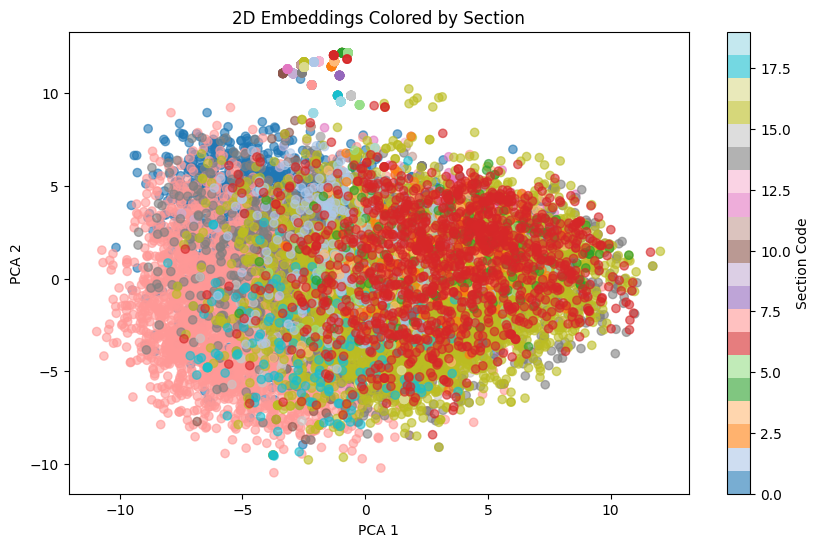

In [44]:
# Plot colored by section
plt.figure(figsize=(10, 6))
sections = chunk_df['section'].astype('category').cat.codes
plt.scatter(chunk_df['pca1'], chunk_df['pca2'], c=sections, cmap='tab20', alpha=0.6)
plt.title('2D Embeddings Colored by Section')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Section Code')
plt.savefig('section_plot.jpg')
plt.show()